In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from pred_strength import prediction_strength_cross_validation

sns.set()

# Métodos de Clustering
## K-means

K-Means es uno de los algoritmos de aprendizaje automático no supervisado más utilizados para el agrupamiento o clustering de datos. Su objetivo es dividir un conjunto de datos en grupos o clústeres de manera que los elementos dentro de un mismo clúster sean similares entre sí y, al mismo tiempo, diferentes de los elementos en otros clústeres. Este algoritmo es útil para descubrir patrones y estructuras en los datos sin necesidad de etiquetas o categorías predefinidas.

Para este tipo de algoritmo vamos a usar el siguiente dataset [mall_customers.csv](https://www.kaggle.com/datasets/shwetabh123/mall-customers). Este dataset posee datos de clientes que asisten a un Mall, edad, ingresos anuales y un score dado el nivel de gastos en el Mall. Se busca establecer diferente tipo de clientes que nos permitan establecer campañas de marketing de préstamos más personalizadas.

In [2]:
# Cargamos los datos con pandas
df = pd.read_csv("mall_customers.csv")
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
df.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

Para este problema, no vamos a usar la edad para establecer tipos de clientes. Nos vamos a quedar con **Annual Income (k$)** y **Spending Score (1-100)**

In [5]:
X = df.iloc[:, [3,4]].values
X = X.astype('float64') 

Los métodos de clustering usan distancia, por lo que es apropiado escalar en similar magnitud a los atributos.

In [6]:
# Los metodos de clustering usan distancia, por lo que es apropiado escalar en similar magnitud a los atributos.
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

Un problema que tenemos es que K-means necesita de entrada el número de clusters que queremos calcular. Pero en este problema no tenemos idea de cuántos tipos de clientes tenemos. Por lo que necesitamos establecer de alguna forma este número. Una forma de hacerlo usando la *Suma de Cuadrados Intracluster* (WCSS) y ver cual es el número que cluster que minimiza este valor.

Este procedimiento es algo parecido a la validación cruzada en aprendizaje supervisado.

Vamos a usar de sklearn el modelo [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [7]:
from sklearn.cluster import KMeans

In [8]:
# Vamos a calcular diferentes modelos de K-means, cambiando la cantidad de cluster en cada iteración
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i,       
                    init = "k-means++",     # Esta forma busca una inicialización que converga más rapido que incializar al azar 
                    max_iter = 300,         # El numero maximo de iteraciones
                    n_init = 10,            # Cuanta veces repite la ejecucion del algoritmo hasta que se quede con el mejor caso
                    random_state = 42)
    kmeans.fit(scaled_X)
    wcss.append(kmeans.inertia_)            # SKlearn le llama inercia a WCSS

Ahora grafiquemos los resultados

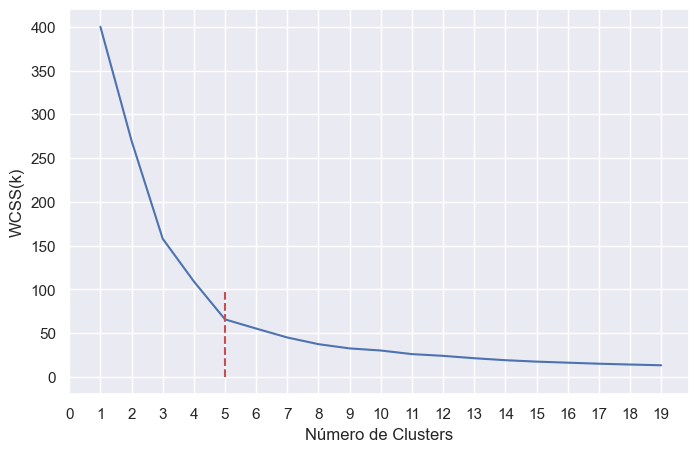

In [9]:
plt.figure(figsize=(8, 5)) 
plt.plot(range(1,20), wcss)
plt.plot([5, 5], [0, 100], color="r", linestyle="--")
plt.xlabel("Número de Clusters", fontsize=12)
plt.ylabel("WCSS(k)", fontsize=12)
plt.xticks(np.arange(0, 20, step=1))
plt.show()

Lo que tenemos que ver acá, medio a ojo, es cual el mínimo número de clusters en donde WCSS(k) empieza a estabilizarse. Este método se llama el **método del codo**.

Otra métrica que podemos ver es el score de la silueta. El cual nos mide una observación que tan similar es en su propio cluster (cohesión) comparado con otros clusters (separación). Para cada observación, el valor va de -1 a 1, donde un valor alto indica que la observación coincide bien con su propio grupo y no con los grupos vecinos.

Este puntaje se puede usar con cualquier medida de distancia.

El puntaje que vamos a calcular aquí es la media de todas las observaciones.

In [10]:
from sklearn.metrics import silhouette_score

# Vamos a calcular diferentes modelos de K-means, cambiando la cantidad de cluster en cada iteración
silhouette_list = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters = i,       
                    init = "k-means++",     # Esta forma busca una inicialización que converga más rapido que incializar al azar 
                    max_iter = 300,         # El numero maximo de iteraciones
                    n_init = 10,            # Cuanta veces repite la ejecucion del algoritmo hasta que se quede con el mejor caso
                    random_state = 42)
    y = kmeans.fit_predict(scaled_X)

    # Calculamos el indice de silueta
    silhouette_list.append(silhouette_score(scaled_X, y, metric="euclidean"))           


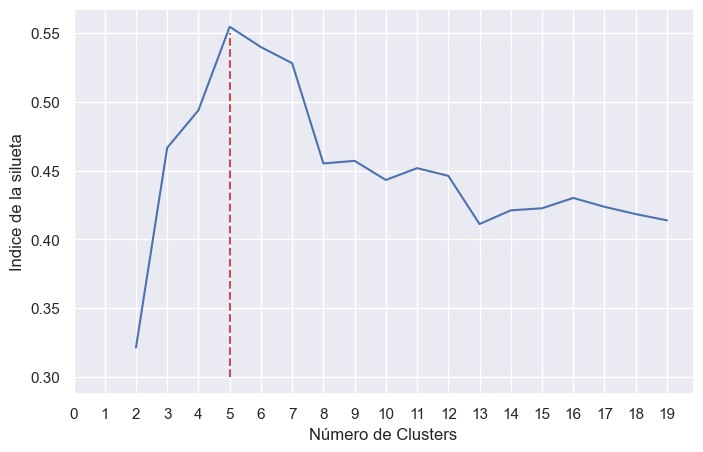

In [11]:
plt.figure(figsize=(8, 5)) 
plt.plot(range(2,20), silhouette_list)
plt.plot([5, 5], [0.3, 0.55], color="r", linestyle="--")
plt.xlabel("Número de Clusters", fontsize=12)
plt.ylabel("Indice de la silueta", fontsize=12)
plt.xticks(np.arange(0, 20, step=1))
plt.show()

Lo que vemos aquí es que el score de silueta promedio es mayor en k=5.

Por último, validemos con una tercera métrica usando la métrica de fuerza de predicción, haciendo una validación cruzada de 5 folds y repitiendo esto 30 veces de 2 a 19 cantidad de clusters.

In [12]:
results = np.zeros((18, 2))
for i in range(2, 20):
    
    loop_result = np.zeros((30, 2))

    for rep in range(30):

        # Y hacemos validación cruzada de 5-Folds.
        pred_stre_mean, pred_stre_std = prediction_strength_cross_validation(scaled_X,
                                                                             KMeans(n_clusters = i, 
                                                                                    init = "k-means++",    
                                                                                    max_iter = 300,   
                                                                                    n_init = 10,
                                                                                    random_state = 42),
                                                                             cross_validation_split=5)
        
        loop_result[rep, 0] = pred_stre_mean
        loop_result[rep, 1] = pred_stre_std

    results[i-2, 0] = np.mean(loop_result[:, 0])
    results[i-2, 1] = np.mean(loop_result[:, 1])

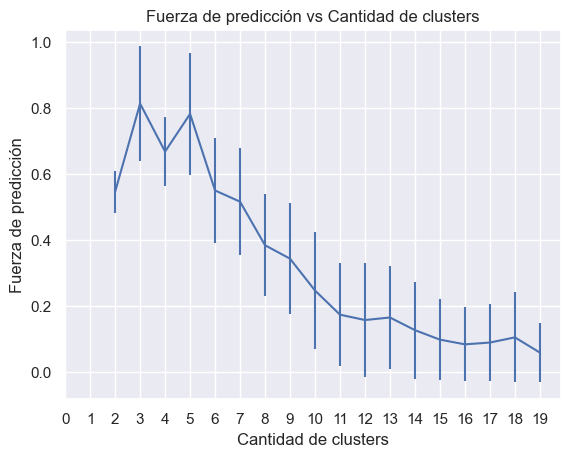

In [13]:
plt.errorbar([*range(2, 20)], results[:, 0], yerr=results[:, 1])
plt.xlabel("Cantidad de clusters")
plt.ylabel("Fuerza de predicción")
plt.title("Fuerza de predicción vs Cantidad de clusters")
plt.xticks(np.arange(0, 20, step=1))
plt.show()

Acá vemos que 3 y 5 clusters dan los mejores resultados, que son justamente donde ocurren los cambios más grandes en el método de los codos, y en el puntaje de silueta el mayor caso es 5.

Dado todos los resultados, vamos a elegir K=5

In [14]:
# Aplicar el método de k-means para segmentar el data set
kmeans = KMeans(n_clusters = 5, init="k-means++", max_iter = 300, n_init = 10, random_state = 0)

In [15]:
y_kmeans = kmeans.fit_predict(scaled_X)

Ahora visualizamos a los clusters

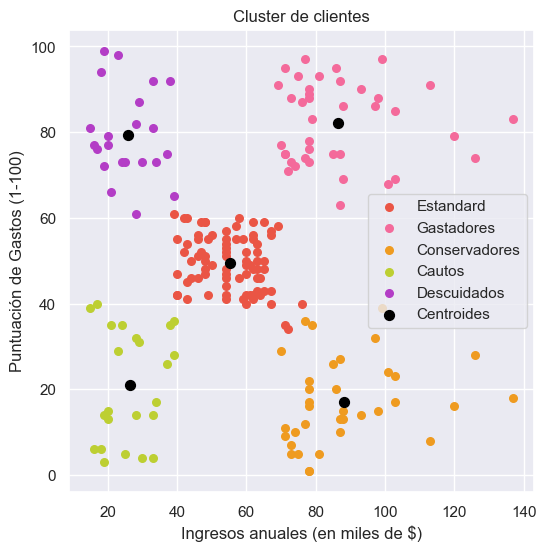

In [16]:
# Visualización de los clusters
plt.figure(figsize=(6, 6)) 
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 30, c = "#ea5545", label = "Estandard")
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 30, c = "#f46a9b", label = "Gastadores")
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 30, c = "#ef9b20", label = "Conservadores")
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 30, c = "#bdcf32", label = "Cautos")
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 30, c = "#b33dc6", label = "Descuidados")

re_scaled_centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(re_scaled_centroids[:,0], re_scaled_centroids[:,1], s = 50, c = "black", label = "Centroides")
plt.title("Cluster de clientes", fontsize=12)
plt.xlabel("Ingresos anuales (en miles de $)", fontsize=12)
plt.ylabel("Puntuación de Gastos (1-100)", fontsize=12)
plt.legend()
plt.show()

Si ahora quisieramos usar a esta clusterización como información para nuestro dataframe, se puede hacer:

In [17]:
df['Cluster'] = y_kmeans
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,3
1,2,Male,21,15,81,4
2,3,Female,20,16,6,3
3,4,Female,23,16,77,4
4,5,Female,31,17,40,3


O inclusive guardar el nombre de categorias que elegimos

In [18]:
categories = {
    0: "standard",
    1: "spenders",
    2: "conservatives",
    3: "cautious",
    4: "careless"
}

df["Client category"] = df["Cluster"].replace(categories)

In [19]:
df.head(10)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster,Client category
0,1,Male,19,15,39,3,cautious
1,2,Male,21,15,81,4,careless
2,3,Female,20,16,6,3,cautious
3,4,Female,23,16,77,4,careless
4,5,Female,31,17,40,3,cautious
5,6,Female,22,17,76,4,careless
6,7,Female,35,18,6,3,cautious
7,8,Female,23,18,94,4,careless
8,9,Male,64,19,3,3,cautious
9,10,Female,30,19,72,4,careless


## Gaussian Mixture Model

K-means es simple y relativamente fácil de entender, pero su simplicidad plantea desafíos prácticos en su aplicación. La naturaleza no probabilística de K-means y el uso de simplemente una distancia desde el centro del grupo para asignar la membresía del grupo conduce a un rendimiento deficiente en muchas situaciones del mundo real. 

Un **Gaussian Mixture Model** intenta encontrar una mezcla de distribuciones de probabilidad gaussianas multidimensionales que modelen mejor cualquier conjunto de datos de entrada. Veamos entonces a **Gaussian Mixture Model**, que pueden verse como una extensión de las ideas detrás de K-means.

Vamos a usar de sklearn el modelo [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)

In [20]:
from sklearn.mixture import GaussianMixture

In [21]:
gmm = GaussianMixture(n_components=5,           # Debemos definir el numero de distribuciones a definir
                      covariance_type='full',   # Es como vamos a calcular la covarianza. El caso elegido es el más inefiente pero mejores
                      random_state=0)           # resultados.   

In [22]:
# Observese que no es necesario escalar, aunque es recomendable
gmm = gmm.fit(X)

Una gran ventaja de este método es que podemos obtener las probabilidades de pertenecer a un cluster.

In [23]:
y_gmm = gmm.predict(X)
y_probs = gmm.predict_proba(X)

In [24]:
y_probs[:5, :]

array([[1.57646362e-05, 1.87994402e-08, 5.19973770e-08, 9.99032168e-01,
        9.51996351e-04],
       [1.62759672e-05, 1.89593733e-04, 4.20852354e-23, 3.94117874e-06,
        9.99790189e-01],
       [2.21099960e-19, 9.52352829e-19, 1.86219457e-04, 9.99813781e-01,
        1.22525998e-12],
       [1.05436234e-04, 1.80084205e-04, 3.79258615e-21, 2.07213221e-05,
        9.99693758e-01],
       [6.47143510e-05, 3.84242794e-08, 4.75683328e-08, 9.98378558e-01,
        1.55664181e-03]])

In [25]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        a = position
        b = nsig * width
        c = nsig * height
        d = angle
        ax.add_patch(Ellipse(a, b, c, angle=d, **kwargs))

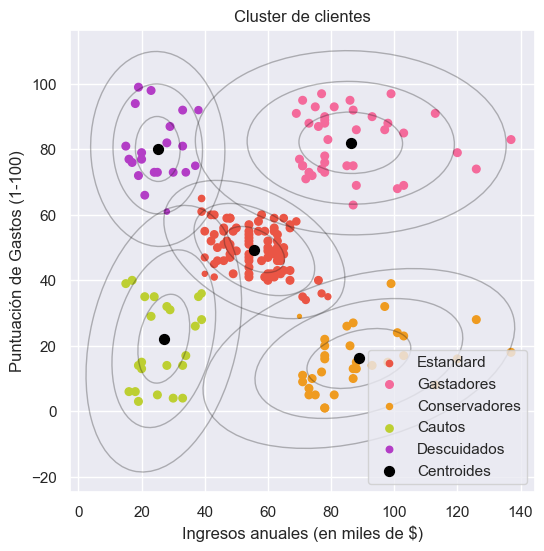

In [26]:
# Visualización de los clusters
plt.figure(figsize=(6, 6)) 

size = 30 * y_probs.max(1) ** 2

plt.scatter(X[y_gmm == 0, 0], X[y_gmm == 0, 1], s = size[y_gmm == 0], c = "#ea5545", label = "Estandard")
plt.scatter(X[y_gmm == 1, 0], X[y_gmm == 1, 1], s = size[y_gmm == 1], c = "#f46a9b", label = "Gastadores")
plt.scatter(X[y_gmm == 2, 0], X[y_gmm == 2, 1], s = size[y_gmm == 2], c = "#ef9b20", label = "Conservadores")
plt.scatter(X[y_gmm == 3, 0], X[y_gmm == 3, 1], s = size[y_gmm == 3], c = "#bdcf32", label = "Cautos")
plt.scatter(X[y_gmm == 4, 0], X[y_gmm == 4, 1], s = size[y_gmm == 4], c = "#b33dc6", label = "Descuidados")

plt.scatter(gmm.means_[:,0], gmm.means_[:,1], s = 50, c = "black", label = "Centroides")

w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=0.3, edgecolor="k", facecolor="none")

plt.title("Cluster de clientes", fontsize=12)
plt.xlabel("Ingresos anuales (en miles de $)", fontsize=12)
plt.ylabel("Puntuación de Gastos (1-100)", fontsize=12)
plt.legend()
plt.show()

Veamos si hicimos **fuerza de predicción** no dice cuántos clusters es el óptimo para este caso.

In [27]:
results = np.zeros((18, 2))
for i in range(2, 20):

    loop_result = np.zeros((30, 2))

    for rep in range(30):

        # Y hacemos validación cruzada de 5-Folds.
        pred_stre_mean, pred_stre_std = prediction_strength_cross_validation(scaled_X,
                                                                             GaussianMixture(n_components=i,
                                                                                             covariance_type='full',
                                                                                             random_state = 42),
                                                                             cross_validation_split=5,
                                                                             type_model='mixture')
        
        loop_result[rep, 0] = pred_stre_mean
        loop_result[rep, 1] = pred_stre_std

    results[i-2, 0] = np.mean(loop_result[:, 0])
    results[i-2, 1] = np.mean(loop_result[:, 1])

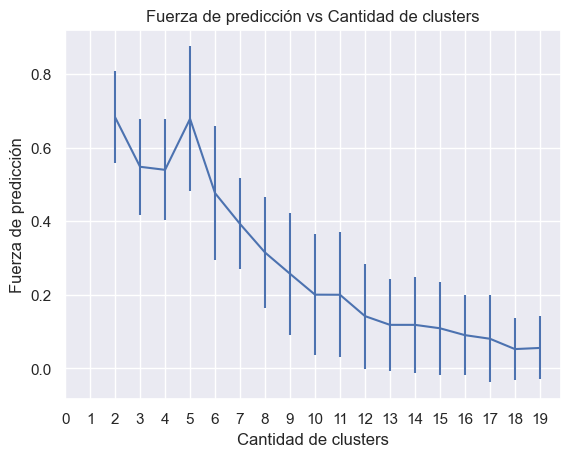

In [28]:
plt.errorbar([*range(2, 20)], results[:, 0], yerr=results[:, 1])
plt.xlabel("Cantidad de clusters")
plt.ylabel("Fuerza de predicción")
plt.title("Fuerza de predicción vs Cantidad de clusters")
plt.xticks(np.arange(0, 20, step=1))
plt.show()

Vemos que para el modelo de mixtura es mucho más claro la **elección de 5 clusters**.

Otra gran ventaja de este modelo es que ahora no solo podemos usarlo como cluster, sino para obtener valores sintéticos que se comporten como datos. Por ejemplo, para nuestro caso podemos obtener clientes que tengan un comportamiento de gastadores y de conservadores:

In [29]:
Xnew, ynew = gmm.sample(400)

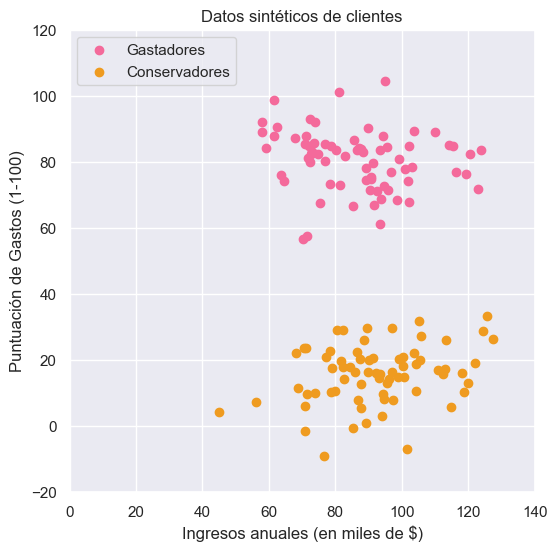

In [30]:
# Visualización de los clusters
plt.figure(figsize=(6, 6)) 

size = 30 * y_probs.max(1) ** 2

plt.scatter(Xnew[ynew == 1, 0], Xnew[ynew == 1, 1], c = "#f46a9b", label = "Gastadores")
plt.scatter(Xnew[ynew == 2, 0], Xnew[ynew == 2, 1], c = "#ef9b20", label = "Conservadores")

plt.xlim([0, 140])
plt.ylim([-20, 120])

plt.title("Datos sintéticos de clientes", fontsize=12)
plt.xlabel("Ingresos anuales (en miles de $)", fontsize=12)
plt.ylabel("Puntuación de Gastos (1-100)", fontsize=12)
plt.legend()
plt.show()

Por último, se deja el enlace de [SKlearn](https://scikit-learn.org/stable/modules/clustering.html) que menciona todo sus algoritmos de clustering, con casos de usos y escalabilidad